# Week 2: End-to-end ML Project. Pre-processing Pipeline

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Precision options
np.set_printoptions(precision=2)
pd.options.display.float_format = '{:.3f}'.format

"""
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
"""

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## 1. Get the Data

First of all let's import the data from the CSV file.

In [2]:
filepath = os.path.abspath(os.path.join('datasets', 'kings_county_house_data.csv'))
print('File path: {}'.format(filepath))
housing = pd.read_csv(filepath, dtype={'zipcode': str})

File path: D:\Python\P4DS\datasets\kings_county_house_data.csv


We can get an overall idea of the fields available using the `DataFrame.info()` and `DataFrame.describe()` methods.

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null object
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(14), object(2)
memory usage: 3.5+ MB


In [4]:
housing.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
count,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000,21613.000
mean,4580301520.865,540088.142,3.371,2.115,2079.900,15106.968,1.494,0.008,0.234,3.409,7.657,1788.391,291.509,1971.005,84.402,47.560,-122.214,1986.552,12768.456
std,2876565571.312,367127.196,0.930,0.770,918.441,41420.512,0.540,0.087,0.766,0.651,1.175,828.091,442.575,29.373,401.679,0.139,0.141,685.391,27304.180
min,1000102.000,75000.000,0.000,0.000,290.000,520.000,1.000,0.000,0.000,1.000,1.000,290.000,0.000,1900.000,0.000,47.156,-122.519,399.000,651.000
25%,2123049194.000,321950.000,3.000,1.750,1427.000,5040.000,1.000,0.000,0.000,3.000,7.000,1190.000,0.000,1951.000,0.000,47.471,-122.328,1490.000,5100.000
50%,3904930410.000,450000.000,3.000,2.250,1910.000,7618.000,1.500,0.000,0.000,3.000,7.000,1560.000,0.000,1975.000,0.000,47.572,-122.230,1840.000,7620.000
75%,7308900445.000,645000.000,4.000,2.500,2550.000,10688.000,2.000,0.000,0.000,4.000,8.000,2210.000,560.000,1997.000,0.000,47.678,-122.125,2360.000,10083.000
max,9900000190.000,7700000.000,33.000,8.000,13540.000,1651359.000,3.500,1.000,4.000,5.000,13.000,9410.000,4820.000,2015.000,2015.000,47.778,-121.315,6210.000,871200.000


## 2. Create a Test Set

Creating a test set is theoretically simple: pick some instances randomly, typically 20% of the dataset (or less if your dataset is very large), and set them aside. We will use a function from `scikit-learn` which splits a dataset into training and test set.

In [5]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [6]:
train_set.shape, test_set.shape

((17290, 21), (4323, 21))

In this way we would just be doing a simple randomized sampling. But this might not be a representative sampling of the whole dataset, if we do not preserve the proportions (or percentages) of significant input features. Let's hypothesize that we learned from expert the `sqft_living` field is an important predictor for the house price. 

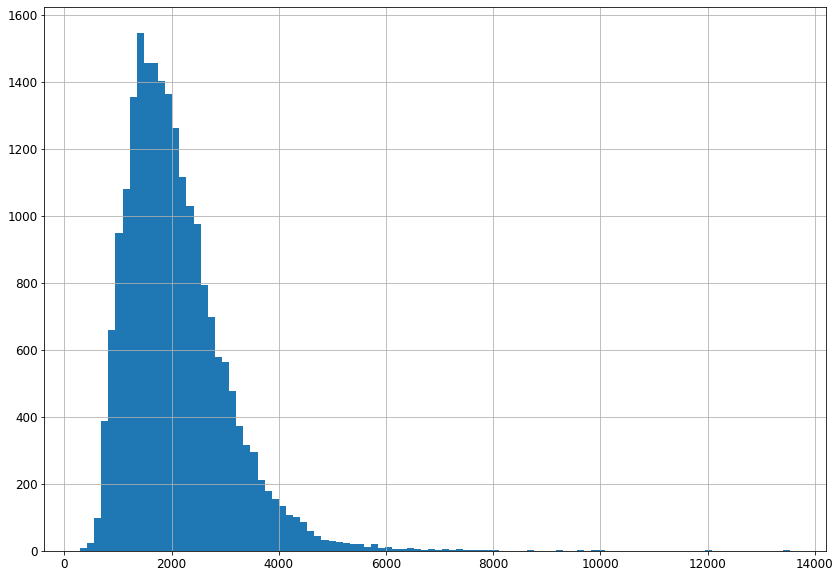

In [7]:
housing.sqft_living.hist(bins=100, figsize=(14,10))
plt.show()

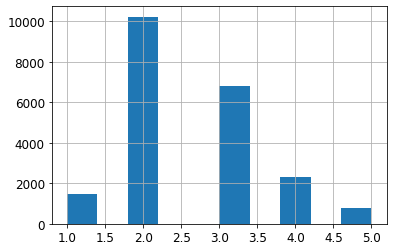

In [8]:
housing["sqft_living_cat"] = pd.cut(housing.sqft_living, 
                                    bins=[0., 1000., 2000., 3000., 4000., np.inf],
                                    labels=[1, 2, 3, 4, 5]
                                   )
housing['sqft_living_cat'].hist()
plt.show()

In [9]:
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing.sqft_living_cat):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [10]:
strat_train_set.shape, strat_test_set.shape

((17290, 22), (4323, 22))

In [11]:
strat_train_set.sqft_living_cat.value_counts() / len(strat_train_set)

2   0.473
3   0.316
4   0.106
1   0.069
5   0.036
Name: sqft_living_cat, dtype: float64

In [12]:
strat_test_set.sqft_living_cat.value_counts() / len(strat_test_set)

2   0.473
3   0.316
4   0.106
1   0.069
5   0.036
Name: sqft_living_cat, dtype: float64

In [13]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("sqft_living_cat", axis=1, inplace=True)

## 3. Discover and Visualize the Data to Gain Insights

### 3.1 Outlier Detection (optional)

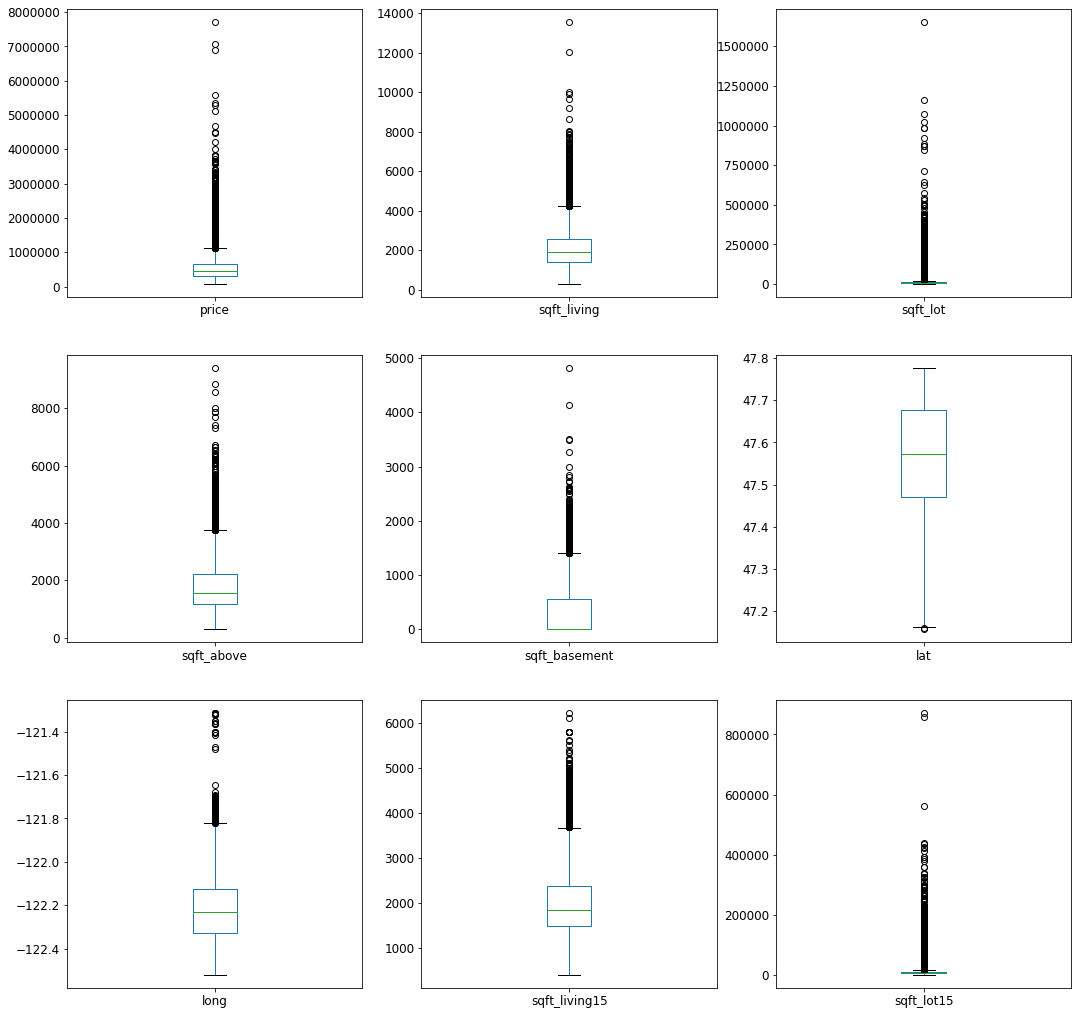

In [14]:
p = housing[
    ['price', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 
     'lat', 'long', 'sqft_living15', 'sqft_lot15']
].plot.box(subplots=True, layout=(3, 3), figsize=(18,18))

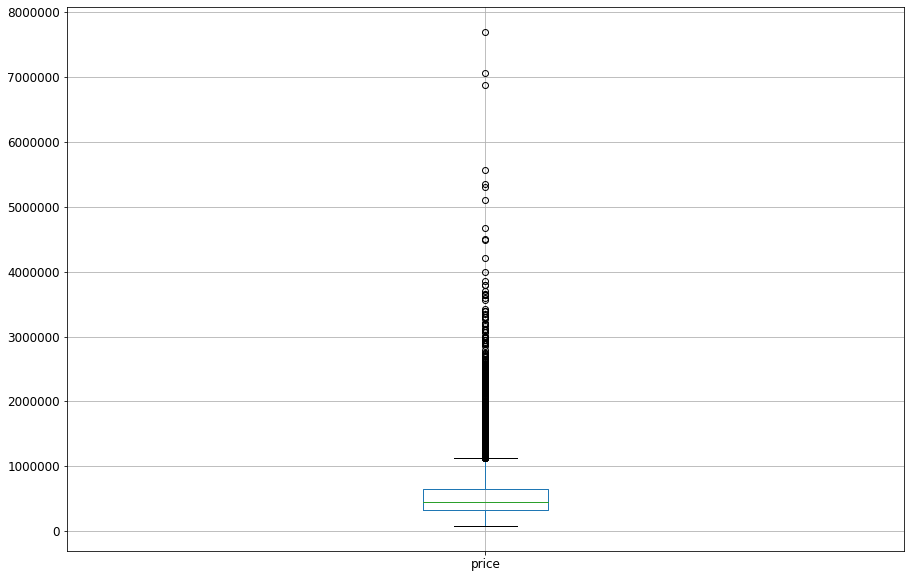

In [15]:
housing[['price']].boxplot(figsize=(15,10))

Box plot use the IQR method to display data and outliers(shape of the data) but in order to be get a list of identified outlier, we will need to use the mathematical formula and retrieve the outlier data.

Wikipedia Definition:
_The interquartile range (IQR), also called the midspread or middle 50%, or technically H-spread, is a measure of statistical dispersion, being equal to the difference between 75th and 25th percentiles, or between upper and lower quartiles, $IQR = Q_3 − Q_1$.

In other words, the IQR is the first quartile subtracted from the third quartile; these quartiles can be clearly seen on a box plot on the data.

It is a measure of the dispersion similar to standard deviation or variance, but is much more robust against outliers._

If a data point is below $Q_1 - 1.5\times IQR$ or above $Q_3 + 1.5\times IQR$ then it's an outlier.

<b>Exercise 1:</b> Compute for me the count of outliers in our training set with respect to the `price` feature. (Hint: check the `DataFrame.quantile()` method and find a way to count the occurrences of values in a column of a DataFrame.) Additionally, write the code to remove those outliers. 

In [16]:
Q1, Q3 = housing.price.quantile([0.25, 0.75])
Q1, Q3

(321950.0, 645000.0)

In [17]:
Q1, Q3 = np.percentile(housing.price, [25, 75])
Q1, Q3

(321950.0, 645000.0)

In [18]:
IQR = Q3 - Q1
IQR

323050.0

In [19]:
outlier_up = Q3 + 1.5 * IQR
outlier_down = Q1 - 1.5 * IQR
outlier_up_count = housing[housing['price'] > outlier_up]
outlier_up_count

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,sqft_living_cat
5,7237550310,20140512T000000,1225000.000,4,4.500,5420,101930,1.000,0,0,...,3890,1530,2001,0,98053,47.656,-122.005,4760,101930,5
21,2524049179,20140826T000000,2000000.000,3,2.750,3050,44867,1.000,0,4,...,2330,720,1968,0,98040,47.532,-122.233,4110,20336,4
49,822039084,20150311T000000,1350000.000,3,2.500,2753,65005,1.000,1,2,...,2165,588,1953,0,98070,47.404,-122.451,2680,72513,3
69,1802000060,20140612T000000,1325000.000,5,2.250,3200,20158,1.000,0,0,...,1600,1600,1965,0,98004,47.630,-122.215,3390,20158,4
125,4389200955,20150302T000000,1450000.000,4,2.750,2750,17789,1.500,0,0,...,1980,770,1914,1992,98004,47.614,-122.212,3060,11275,3
153,7855801670,20150401T000000,2250000.000,4,3.250,5180,19850,2.000,0,3,...,3540,1640,2006,0,98006,47.562,-122.162,3160,9750,5
216,46100204,20150221T000000,1505000.000,5,3.000,3300,33474,1.000,0,3,...,1870,1430,1957,1991,98040,47.567,-122.210,3836,20953,4
246,2025069065,20140929T000000,2400000.000,4,2.500,3650,8354,1.000,1,4,...,1830,1820,2000,0,98074,47.634,-122.072,3120,18841,4
269,7960900060,20150504T000000,2900000.000,4,3.250,5050,20100,1.500,0,2,...,4750,300,1982,2008,98004,47.631,-122.223,3890,20060,5
270,4054500390,20141007T000000,1365000.000,4,4.750,5310,57346,2.000,0,0,...,5310,0,1989,0,98077,47.728,-122.042,4180,47443,5


In [20]:
outlier_up_count['price'].value_counts()

1150000.000    28
1250000.000    27
1200000.000    26
1400000.000    23
1300000.000    21
               ..
2479000.000     1
1599950.000     1
1563100.000     1
1895000.000     1
2048000.000     1
Name: price, Length: 485, dtype: int64

In [21]:
outlier_down_count = housing[housing['price'] < outlier_down].shape[0]
outlier_down_count

0

Are the outliers legitimate or should we remove them?

In [22]:
housing2 = housing[housing['price'] <= outlier_up]
housing2.shape

(20467, 22)

In [23]:
h3 = housing.drop(index=outlier_up_count.index)
h3.shape

(20467, 22)

In [24]:
housing.shape

(21613, 22)

### 3.2 Visualize geographical data

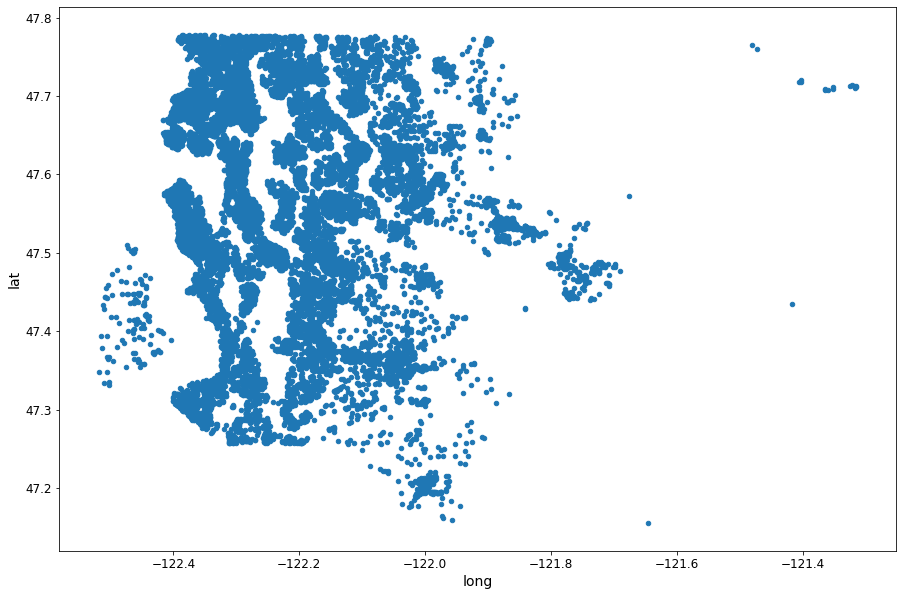

In [25]:
housing.plot(kind="scatter", x="long", y="lat", figsize=(15,10))
plt.show()

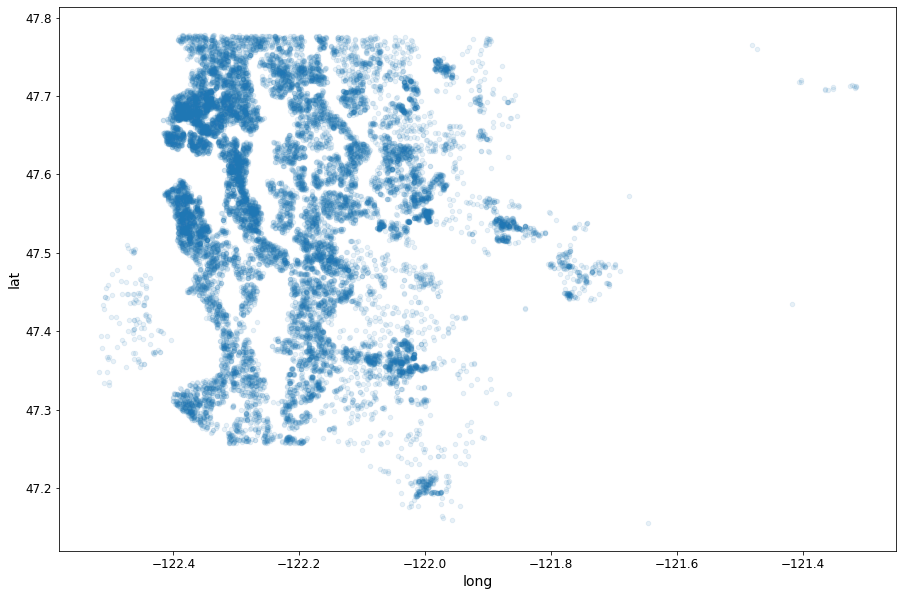

In [26]:
housing.plot(kind="scatter", x="long", y="lat", alpha=0.1, figsize=(15,10))
plt.show()

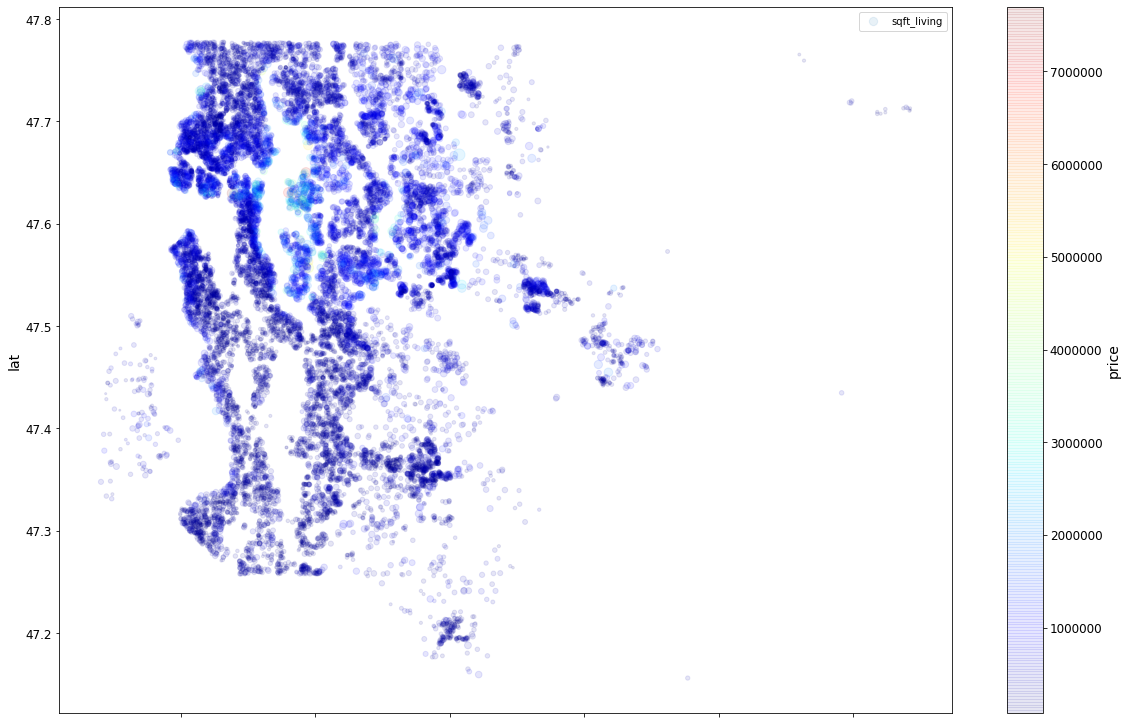

In [27]:
housing.plot(
    kind="scatter", x="long", y="lat", alpha=0.1, figsize=(20,13),
    s=housing["sqft_living"]/100, label="sqft_living",
    c="price", cmap=plt.get_cmap('jet'), colorbar=True
)
plt.legend()
plt.show()

<b>Exercise 2:</b> Using the same colormap (i.e. jet), try to improve the visualization above, setting an upper value that is reasonable, (i.e less or equal to QR3 + 1.5 IQR such as 1,000,000 $), and not the highest value in the range.

Hint: I suggest you to create a custom discrete colorbar by using `matplotlib.colors.BoundaryNorm` as normalizer for your scatterplot. See the `norm` argument in `matplotlib.pyplot.scatter()`: https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.scatter.html

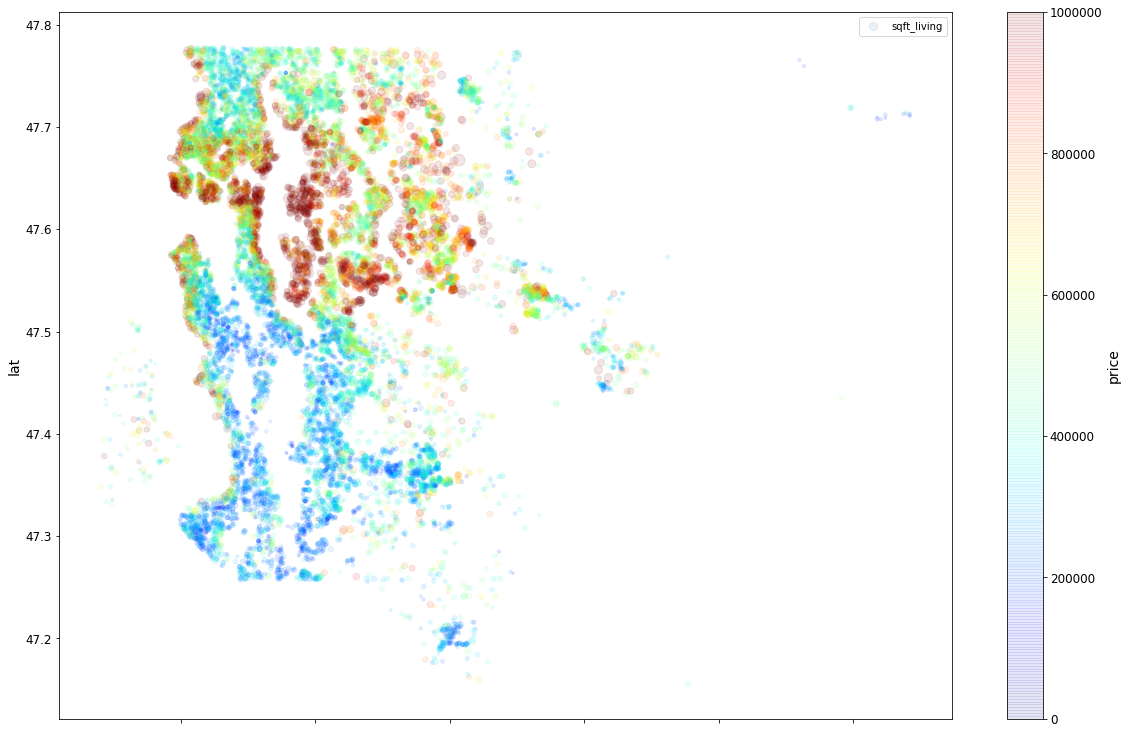

In [28]:
## Write your solution here
"""https://stackoverflow.com/questions/3373256/set-colorbar-range-in-matplotlib"""
housing.plot(
    kind="scatter", x="long", y="lat", alpha=0.1, figsize=(20,13),
    s=housing["sqft_living"]/100, label="sqft_living",
    c="price", cmap=plt.get_cmap('jet'), norm=mpl.colors.Normalize(vmin=0, vmax=1000000), colorbar=True
)
plt.legend()
plt.show()

### 3.2 Looking for correlations

The dataset is not that big, and we can compute the standard correlation coefficient (Pearson’s r coefficient) between every two features using the `DataFrame.corr()` method:

In [29]:
corr_matrix = housing.corr()
corr_matrix["price"].sort_values(ascending=False)

price            1.000
sqft_living      0.702
grade            0.667
sqft_above       0.606
sqft_living15    0.585
bathrooms        0.525
view             0.397
sqft_basement    0.324
bedrooms         0.308
lat              0.307
waterfront       0.266
floors           0.257
yr_renovated     0.126
sqft_lot         0.090
sqft_lot15       0.082
yr_built         0.054
condition        0.036
long             0.022
id              -0.017
Name: price, dtype: float64

N.B. The correlation coefficient only measures linear correlations, and it may completely miss nonlinear correlation factors. 

Another way to check for correlation visually is to use the `scatter_matrix()` utility function offered by Pandas, which leverages `matplotlib`, or seaborn's `pairplot()` function.

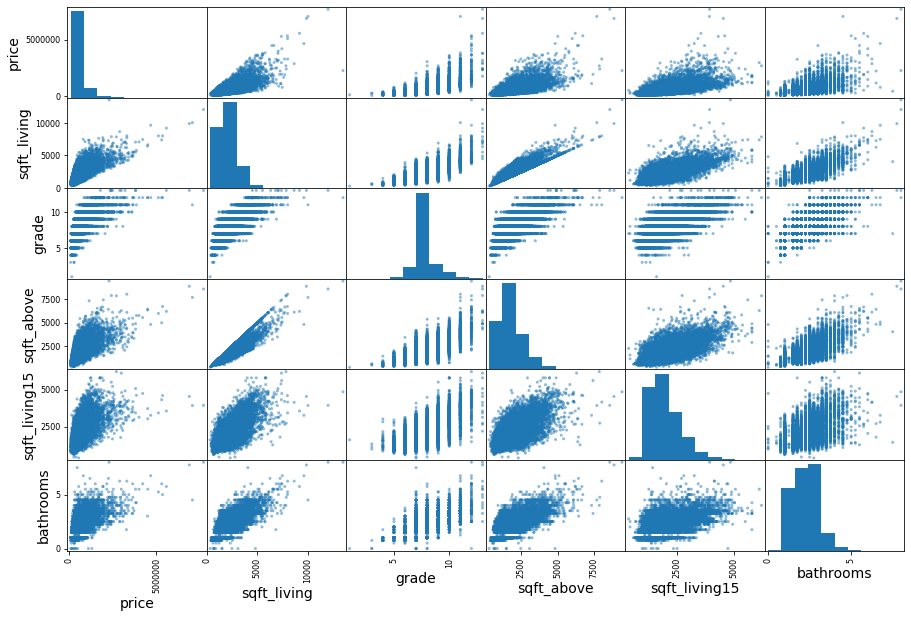

In [30]:
attributes = ["price", "sqft_living", "grade",
              "sqft_above", "sqft_living15", "bathrooms"]
pd.plotting.scatter_matrix(housing[attributes], figsize=(15, 10))
plt.show()

In [31]:
import seaborn as sns
ax = sns.pairplot(housing[attributes])

ModuleNotFoundError: No module named 'seaborn'

We can then start using boxplots or violinplots to further investigate targeted correlations, such as 'grade' vs 'price' or 'floors' vs 'price'.

<b>Exercise 3:</b> write a function that takes a categorical or ordinal feature as a first argument, the size of a figure as a second argument and plots, using seaborn, a set of boxplots of the price distribution for each category in the input categorical feature.

In [ ]:
## Write you solution here.
# Populate the function body. I've written the function interfaxe (i.e. its API) for you
def print_boxplot(feature, figsize=(14, 6)):
    """
    write your function here
    """
    sns.set(rc={'figure.figsize':(figsize)})
    sns.boxplot(x=feature, y="price", data=housing)
## Try your function to plot 'grade' vs 'price'.
print_boxplot('grade')

In [ ]:
## Try your function to plot 'floors' vs 'price'.
print_boxplot('floors', figsize=(12, 12))

In [ ]:
## Try your function to plot 'bathrooms' vs 'price'.
print_boxplot('bathrooms', figsize=(20, 12))

## 4. Preparing the Data for Machine Learning Algorithms

### 4.1 Data Cleaning

In [ ]:
housing = strat_train_set.drop("price", axis=1) # drop labels for training set
housing_labels = strat_train_set["price"].copy()

In [ ]:
## Look for rows with incomplete values
incomplete_rows = housing[housing.isnull().any(axis=1)]
incomplete_rows

As there is no missing value we do not need to do this. We can ignore it

In [ ]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")
housing_num = housing.select_dtypes(include=[np.number])
imputer.fit(housing_num.values)
imputer.statistics_

In [ ]:
housing_num.median().values

In [ ]:
X = imputer.transform(housing_num)
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)
housing_tr.sort_values(by='bathrooms', ascending=True)

In [ ]:
housing_tr.loc[[14423, 1149, 6994]]

We might want to look for weird values as well...as it can be seen from the boxplotof bathrooms vs price some houses seem to have no bathroom. This is most likely an error and we may wont to replace those values with the median values for for bathrooms as well.

In [ ]:
housing_tr.loc[housing['bathrooms'] == 0, 'bathrooms'] = np.nan
housing_tr.bathrooms.isnull().value_counts()

In [ ]:
housing_tr.bathrooms.fillna(housing_tr.bathrooms.median(), inplace=True)

In [ ]:
housing_tr.loc[[14423, 1149, 6994]]

### 4.2 Transform Rows

It is always a good practice to write functions (or classes) to perform data transformations, so that these operations can later be performed in a reliable and reproducible way.

Below, we have a method that replaces zeroes with the median values for bathrooms, and splits the date the house was sold into `month_bought` and `yr_bought`, then computes the `age` (in years) of teh house when it was sold and introduces a boolean flag (`renovated_flag`) that states whether the house was renovated or not before being sold. It then removes features deemed not relevant (such as `id`, `date`, `yr_built`, `yr_bought`, `month_bought`, `yr_renovated`).

In [ ]:
housing['date']

In [ ]:
def transform_housing_rows(housing_df):
    """
     housing_df['date_as_ordinal'] = housing.date.apply(
         lambda d: date(int(d[:4]), int(d[4:6]), int(d[6:8])).toordinal()
     )
    """
    res = housing_df.copy()
    res.loc[housing_df['bathrooms'] == 0, 'bathrooms'] = np.nan
    res.bathrooms.fillna(res.bathrooms.median(), inplace=True)
    if 'date' in res.columns.values:
        res['yr_bought'] = res['date'].apply(lambda d: int(d[:4]))
        res['month_bought'] = res['date'].apply(lambda d: int(d[4:6]))
        res['age'] = res['yr_bought'] - housing_df['yr_built']
    res['renovated_flag'] = res['yr_renovated'].apply(lambda el: 0 if el == 0.0  else 1)
    return housing_df.drop(
        columns=['id', 'date', 'yr_built', 'yr_bought', 'month_bought', 'yr_renovated'],
        errors='ignore'
    )
    
housing_proc = transform_housing_rows(housing)
housing_proc.head()

### 4.2 Handling Text and Categorical Attributes

In general we can consider three types of text features: categorical, ordinal, and unstructured.
Unstructured text is more the subject of Natural Language Processing, hence we will not consider its processing/encoding at this stage (and we have no unstructured data). Ordinal data are text categories that imply and intrinsic order such as the set ("BAD", "AVERAGE", "GOOD", "VERY GOOD", "EXCELLENT"). These are generally encodes as integers ("BAD" => 0, "AVERAGE" => 1, "GOOD" => 2, "VERY GOOD" => 3, "EXCELLENT" => 4). These transformations can be handed with custom functions as above.

To handle Categorical Attributes that are not ordinal, a common solution is to create one binary attribute per category. This is called one-hot encoding, because only one attribute will be equal to 1 (hot), while the others will be 0 (cold). The new attributes are sometimes called *dummy attributes*. Scikit-Learn provides a `sklearn.preprocessing.OneHotEncoder` class to convert categorical values into one-hot vectors.

In our case we have the "zipcode" attribute that can be considered as categorical. Each "zipcode" category should become a mutually exclusive dummy attribute

<b>Exercise 4:</b> Use the `OneHotEncoder` class to encode each ZIP code as a separate category. Check the documentation for appropriate use of the `OneHotEncoder` transformer. What kind of output do you get? 

In [ ]:
## Write your solution here



Notice that the output is a SciPy sparse matrix, instead of a NumPy array. This is very useful when you have categorical attributes with thousands of categories. After one-hot encoding, we get a matrix with thousands of columns, and the matrix is full of 0s except for a single 1 per row. 

In [ ]:
housing_zipcode_1hot.toarray()

In [ ]:
cat_encoder.categories_

### 4.3 Custom Transformers (see if we should do this one)

You can define you own transformers creating a class that inherits both from `BaseEstimator` (so that it inherits the `.fit()` method) and the mixin class `TransformerMixin` (so that it acquires the `.tranform()` method)

Here below you can see a transformer that set two new features: `renovated_flag` and `age`.

Transformers can take DataFrames as inputs but always output NumPy arrays, so for some transformations where you find more convenient to work on DataFrame you might prefer just to write you own functions that return a modified DataFrame as we did with `transform_housing_rows()`

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

yr_built_ix = housing.columns.values.tolist().index('yr_built') 
yr_renovated_ix = housing.columns.values.tolist().index('yr_renovated')
print(yr_built_ix, yr_renovated_ix)

class ManipulatedAttributesAdder(BaseEstimator, TransformerMixin):
    
    CURRENT_YEAR = 2017
    
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self # nothing else to do
    
    def transform(self, X):
        age = self.CURRENT_YEAR - X[:, yr_built_ix]
        renovated_flag = np.apply_along_axis(lambda r: 0 if r[yr_renovated_ix] == 0 else 1, 1, X)
        return np.concatenate((X, age[:, np.newaxis], renovated_flag[:, np.newaxis]), axis=1)

attr_adder = ManipulatedAttributesAdder()
housing_extra_attribs = pd.DataFrame(
    attr_adder.transform(housing_num.values),
    columns=[*housing_num.columns.values.tolist(), 'age', 'is_renovated'],
    index=housing_num.index
)
housing_extra_attribs.head(10)

An alternative way to perform this transformation:

### 4.4 Feature Scaling

One of the most important transformations you need to apply to your data is feature scaling. In the great majority of case, Machine Learning algorithms will not perform well when the input numerical attributes have very different scales.

There are two common ways to get all attributes to have the same scale: min-max scaling (using scikit-learn `MinMaxScaler`) and standardization (using scikit-learn `StandardScaler`).

### 4.5 Transformation Pipelines

We are goin to use a `StandardScaler` directly after our `ManipulatedAttributesAdder` class using a Tranformation Pipeline

In [ ]:
housing_num.describe()

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

housing_num_tr = transform_housing_rows(housing_num)
housing_num_prepared = num_pipeline.fit_transform(housing_num_tr)
housing_num_prepared.shape

In [ ]:
housing_num_prepared.min(axis=1), housing_num_prepared.max(axis=1)

Until now, we have handled the categorical columns and the numerical columns separately. It would be more convenient if we had just one transformer capable to handle all columns, applying the appropriate transformations to each column. Solution: we can use scikit-learn `ColumnTransformer`!

In [ ]:
from sklearn.compose import ColumnTransformer

housing_tr = transform_housing_rows(housing)

num_attribs = list(housing_tr.select_dtypes(include=[np.number]))
print(num_attribs)
cat_attribs = ["zipcode"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(categories='auto'), cat_attribs),
])


housing_prepared = full_pipeline.fit_transform(housing_tr)

`OneHotEncoder` returns a sparse matrix, while `num_pipeline` returns a dense matrix. `ColumnTransformer` estimates the density of the final matrix (i.e., the ratio of nonzero cells), and it returns a sparse matrix if the density is lower than a given threshold. In this example, it returns a sparse matrix. 

And now we are done! We have a preprocessing pipeline that takes the full housing data and applies the appropriate transformations to each column.

In [ ]:
housing_prepared

In [ ]:
type(housing_prepared)

## 5. Save all the pre-processed data for the next week

We will use `scipy.sparse.save_npz()` to save the sparse matrix, `np.save()` to save the NumPy arrays as `.npy` binary files, and `pickle` from the Python standard library to save our `full_pipeline`

In [ ]:
"""
import pickle
from scipy.sparse import save_npz

X_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_house_data_prepared.npz'))
y_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_housed_data_prediction.npy'))
train_set_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_housed_data_train_set.csv'))
test_set_filepath = os.path.abspath(os.path.join('..', 'dumps', 'kc_housed_data_test_set.csv'))
pipeline_filepath = os.path.abspath(os.path.join('..', 'dumps', 'full_preprocessing_pipeline'))

# create the "dumps" directory if it does not exist
os.makedirs(os.path.abspath(os.path.join('..', 'dumps')), exist_ok=True)

with open(pipeline_filepath, 'wb') as file_handle:
    pickle.dump(full_pipeline, file_handle)
    
print(type(strat_train_set), type(strat_test_set))

save_npz(X_filepath, housing_prepared)
np.save(y_filepath, housing_labels)
strat_train_set.to_csv(train_set_filepath)
strat_test_set.to_csv(test_set_filepath)
# np.save(train_set_filepath, strat_train_set)
# np.save(test_set_filepath, strat_test_set)
"""

In [ ]:
"""
some_data = strat_train_set.iloc[:10]
some_labels = strat_test_set.iloc[:10]
preprocessed_some_data = full_pipeline.transform(some_data)
"""

### This is the end of the work for Week 2!!

See you next week